In [2]:
%load_ext autoreload
%autoreload 2
from fast_rep.rfd_tools  import load_RFD,find_ori_position,smooth,convert_RFD_delta_MRT
from pylab import *
from fast_rep.bayesian_optim import fit_at_pos_using_map_as_starting_point
import jax
import numpy as np
jax.config.update('jax_enable_x64', True)
jax.config.update("jax_debug_nans", True)
from time import time
import jax.numpy as  jnp
from fast_rep.math_mod.compute_rfd import compute_derivatives
from fast_rep.read_data import load_muli_from_bedGraph


# Load the data and select the ori

dict_keys(['chrI:0-249100'])


Text(0, 0.5, 'inc RFD/ kb')

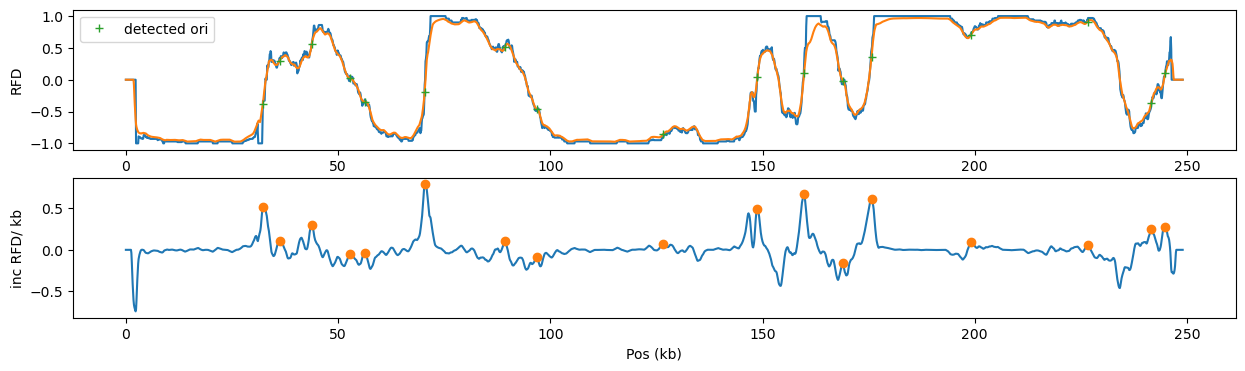

In [13]:
#data = "/home/jarbona/alignExp/notebook/invert_conf/data/NFS/NFS_BTmulti_"
#
#RFD, mean_RFD, Cov_RFD, std_RFD,positif,negatif = load_RFD(root=data, minimum_obs=1)
#
#_,smth_RFD,_,_,_,_ =  load_RFD(root=data,minimum_obs=5,smv=11)
regions_str="chrI"
bedgraph_file="../../data/from_nfs_smv11.bed"
RFD, _, meta = load_muli_from_bedGraph(bedgraph_file,
                                                    regions_str,
                                                    column_specs=["RFD","std_RFD","smth_RFD"])

print(RFD.keys())
key="chrI:0-249100"
rfd = RFD[key]["signals"]["RFD"]
std_RFD = RFD[key]["signals"]["std_RFD"]


smth_RFD = RFD[key]["signals"]["smth_RFD"]

from fast_rep.rfd_tools import find_peaks


resolution = 100
min_dist_ori=3_000   # in bp
pos = np.arange(len(rfd))*resolution

#Detect origin
xis,delta_v,vals=find_ori_position({"rfd":smth_RFD,"positions":pos},min_dist_ori=min_dist_ori,min_rfd_increase_by_kb=0.1) 

f,ax  = subplots(2,1,figsize=(15,4))
ax[0].plot(pos/1000,rfd)
ax[0].plot(pos/1000,smth_RFD)
ax[0].plot(xis/1000,smth_RFD[xis//resolution],"+",label="detected ori")
ax[0].legend()
ax[0].set_xlabel("Pos (kb)")
ax[0].set_ylabel("RFD")


ax[1].plot(pos/1000,delta_v)
ax[1].plot(xis/1000,delta_v[xis//resolution],"o")
ax[1].set_xlabel("Pos (kb)")
ax[1].set_ylabel("inc RFD/ kb")

# Sub sample the data and compute std

In [9]:
delta=15   # subsampling of the refd
fork_speed=2500
measurement_type = "RFD"   # compute the average rfd which is to a scaliing factor equal to deltaMRT

ps,data = convert_RFD_delta_MRT(pos,rfd,speed=fork_speed,resolution=resolution,delta=delta,measurement_type=measurement_type)
r_std = smooth(std_RFD,delta)[::delta]


In [10]:
S = 20.
fit_time = True
model="Exponential"


#Set values for prior
n_ori=len(xis)
initial_lambda = jnp.array([1/(S/2)] * n_ori)
if fit_time:
    init_extra_t = jnp.array([4/S]  * n_ori)
else:
    init_extra_t = None

init_qis = None # jnp.array([0.9]  * n_ori)
#r = optim(pos_to_compute=ps,xis=xis,prior_on_lambda=initial_lambda,prior_on_extra_t=init_extra_t,
#          prior_on_qis=init_qis,fork_speed=fork_speed,
#          data=data,S_phase_duration=S,sigma=r_std,measurement_type=measurement_type,model=model,only_optim=True)
t=time()
r = fit_at_pos_using_map_as_starting_point(pos_to_compute=ps,xis=xis,prior_on_lambda=initial_lambda,prior_on_extra_t=init_extra_t,
          prior_on_qis=init_qis,fork_speed=fork_speed,
          data=data,S_phase_duration=S,sigma=r_std,measurement_type=measurement_type,model=model,only_optim=False)
print(time() - t)

use_qi False
use_extrat True
3.7177650928497314


# Compare fitted data with exp data

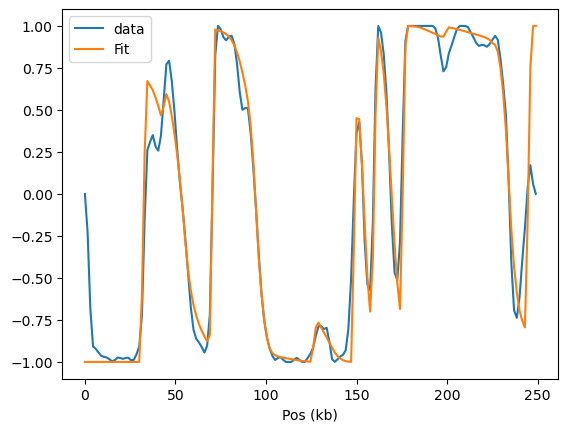

In [11]:
plot(ps/1000,data,label="data")
plot(ps/1000,r["theo"],label="Fit")
xlabel("Pos (kb)")
legend()

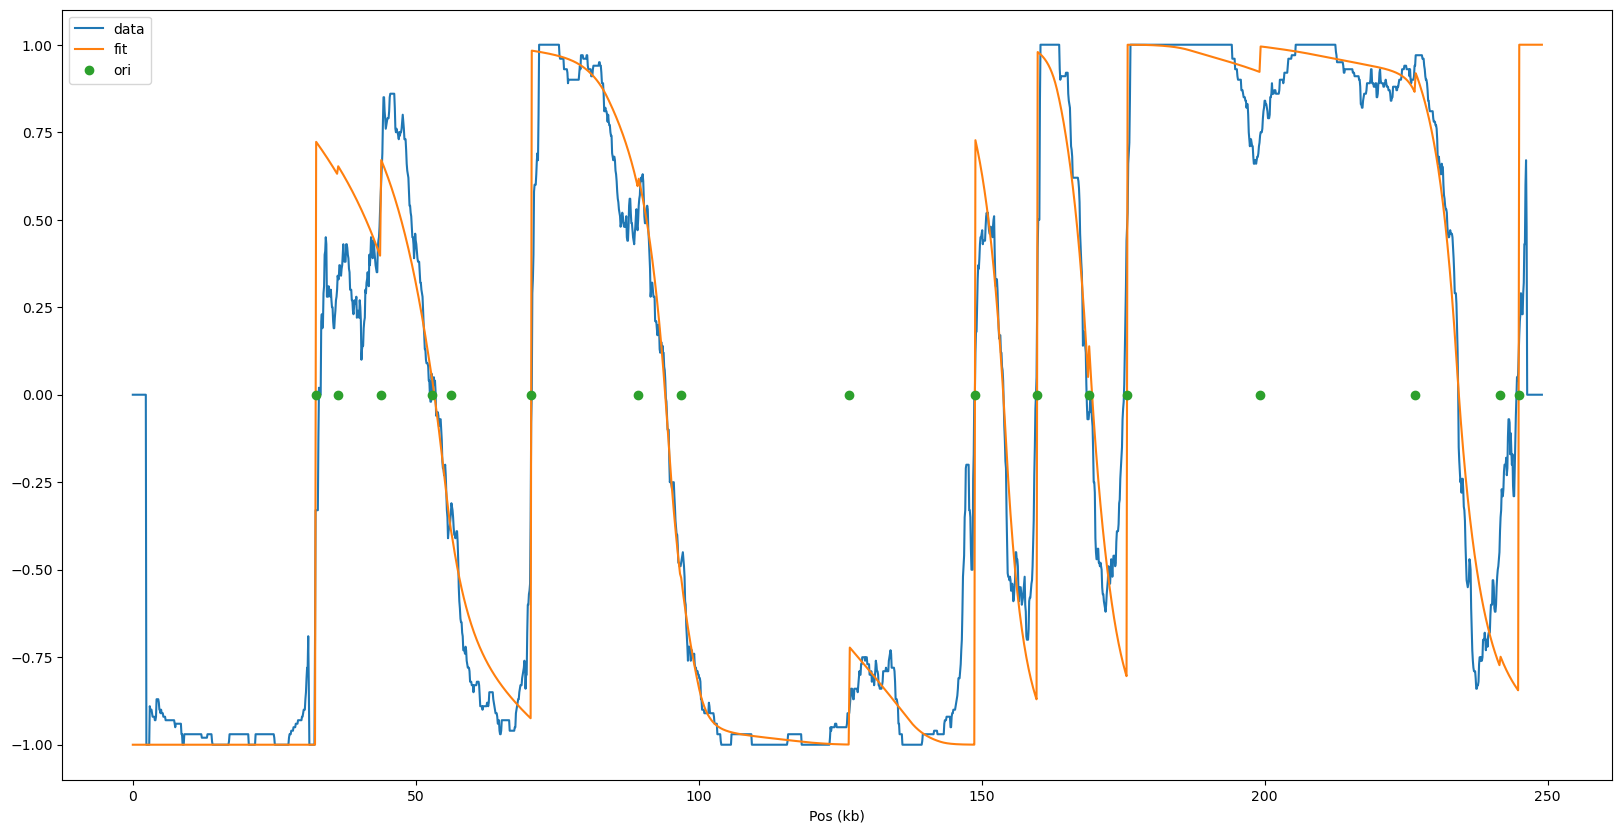

In [12]:
from fast_rep.interface import compute_mrt_and_derivatives_pos
params = r["params"]
mrtr,rfd_sim = compute_mrt_and_derivatives_pos(pos,params["kis"],
                                               params.get("extra_t",np.zeros_like(params["kis"])),
                                                xis, v=fork_speed, model=model,method='central', shift=1,resolution=resolution)
f=figure(figsize=(20,10))
plot(pos/1000,rfd,label="data")
plot(pos/1000,rfd_sim,label="fit")
plot(xis/1000,np.zeros_like(xis),"o",label="ori")
xlabel("Pos (kb)")
legend()

# parameter values

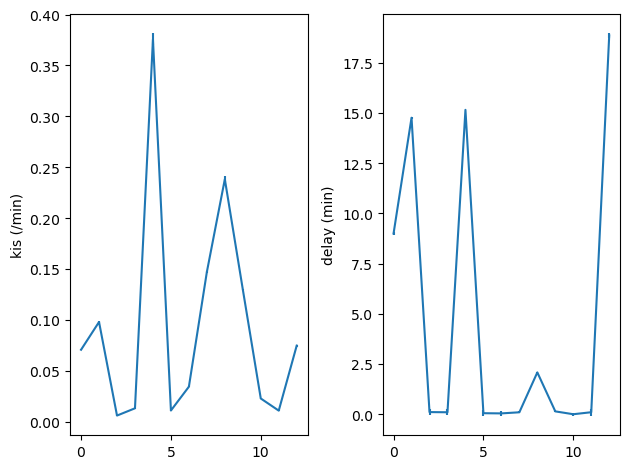

In [37]:
f,axes = subplots(1,2)
ori = range(len(params["kis"]))
axes[0].errorbar(x=ori,y=params["kis"],yerr=params["kis_std"])
axes[0].set_ylabel("kis (/min)")
if "extra_t" in params:
    axes[1].errorbar(x=ori,y=params["extra_t"],yerr=params["extra_t_std"])
    axes[1].set_ylabel("delay (min)")
f.tight_layout()